In [1]:
%%capture
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*
!pip install shap
!pip install pdpbox
import sys
from statsmodels.formula.api import ols
import statsmodels.api as sm
from xgboost import XGBRegressor
import datetime as dt
from sklearn.inspection import permutation_importance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
from pprint import pprint
from sklearn import preprocessing
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.express as px
import plotly.tools as tl
import plotly.graph_objs as go
import plotly as py

df=pd.read_csv('dengue_features_train.csv')
dflabels=pd.read_csv('dengue_labels_train.csv')
dftest=pd.read_csv('dengue_features_test.csv')



def wrangle(df):
    df=pd.read_csv('dengue_features_train.csv',parse_dates=['week_start_date'], index_col = 'week_start_date').sort_index()
    
    return df
df = wrangle(df)








In [2]:
print(df.shape)
print(df.nunique())
df.head()

(1456, 23)
city                                        2
year                                       21
weekofyear                                 53
ndvi_ne                                  1214
ndvi_nw                                  1365
ndvi_se                                  1395
ndvi_sw                                  1388
precipitation_amt_mm                     1157
reanalysis_air_temp_k                    1176
reanalysis_avg_temp_k                     600
reanalysis_dew_point_temp_k              1180
reanalysis_max_air_temp_k                 141
reanalysis_min_air_temp_k                 117
reanalysis_precip_amt_kg_per_m2          1039
reanalysis_relative_humidity_percent     1370
reanalysis_sat_precip_amt_mm             1157
reanalysis_specific_humidity_g_per_kg    1171
reanalysis_tdtr_k                         519
station_avg_temp_c                        492
station_diur_temp_rng_c                   470
station_max_temp_c                         73
station_min_temp_c     

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [3]:
print(dflabels.nunique())
dflabels.head()

city             2
year            21
weekofyear      53
total_cases    135
dtype: int64


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [4]:
dftest.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [5]:
df_train_val = pd.merge(df, dflabels[['weekofyear','total_cases']], on='weekofyear',right_index=True)

df_train_val.head()

df_train_val.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c  

In [6]:
def wrangle(df_train_val):
  df_train_val.drop(columns=['year','weekofyear'])

    
  return df_train_val
df_train_val = wrangle(df_train_val)

In [7]:
df_train_val.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,4
1990-04-30,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,17
1990-04-30,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,24
1990-04-30,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,17
1990-04-30,sj,1990,18,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,22


In [8]:
df_train_val['total_cases'].value_counts()

0      2767
6      1983
3      1960
5      1960
2      1932
       ... 
141      28
461      28
78       28
333      28
154      23
Name: total_cases, Length: 135, dtype: int64

In [9]:
df_train_val.groupby('year')['total_cases'].sum()


year
1990    28313
1991    35819
1992    35819
1993    35322
1994    35819
1995    35819
1996    35819
1997    35819
1998    35819
1999    35322
2000    61333
2001    71638
2002    71638
2003    71638
2004    71638
2005    70644
2006    71638
2007    71638
2008    43325
2009    35819
2010     9808
Name: total_cases, dtype: int64

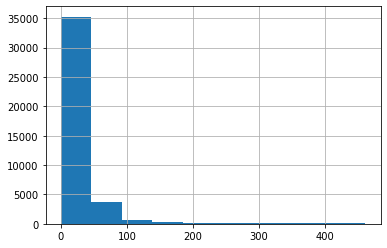

In [10]:
df_train_val['total_cases'].hist()

In [11]:
#we have outliers that exist far beyond our standard range
df_train_val['total_cases'].describe()

count    40538.000000
mean        24.679239
std         43.652454
min          0.000000
25%          5.000000
50%         12.000000
75%         28.000000
max        461.000000
Name: total_cases, dtype: float64

In [12]:
#removal of outliers
#70 is a rounded integer from mean + std
df_train_val= df_train_val.loc[df_train_val['total_cases']<70,:]
#removal of dupe info 
df_train_val.drop(columns=['reanalysis_dew_point_temp_k','reanalysis_relative_humidity_percent',
                           'reanalysis_sat_precip_amt_mm','reanalysis_tdtr_k','station_avg_temp_c','station_diur_temp_rng_c',
                           'station_max_temp_c','station_min_temp_c','station_precip_mm','precipitation_amt_mm','year','weekofyear'],inplace=True)

In [13]:
df_train_val['total_cases'].describe()

count    37664.000000
mean        15.710041
std         15.465948
min          0.000000
25%          4.000000
50%         10.000000
75%         23.000000
max         68.000000
Name: total_cases, dtype: float64

In [14]:
#we have nans 
df_train_val.isnull().sum()

city                                        0
ndvi_ne                                  4936
ndvi_nw                                  1216
ndvi_se                                   438
ndvi_sw                                   438
reanalysis_air_temp_k                     155
reanalysis_avg_temp_k                     155
reanalysis_max_air_temp_k                 155
reanalysis_min_air_temp_k                 155
reanalysis_precip_amt_kg_per_m2           155
reanalysis_specific_humidity_g_per_kg     155
total_cases                                 0
dtype: int64

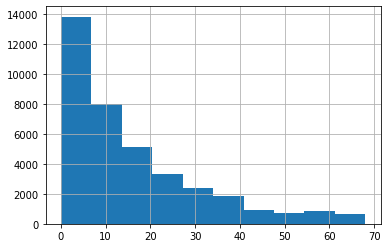

In [15]:
df_train_val['total_cases'].hist()

In [16]:
#log transform the target to account for positive skewness 
df_train_val['total_cases_transformed']  = np.log1p(df_train_val['total_cases'])

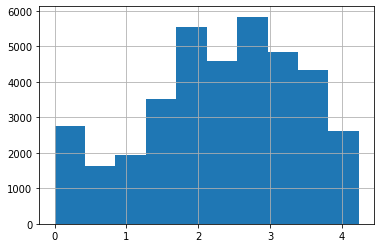

In [17]:
df_train_val['total_cases_transformed'].hist()

In [18]:
#our target is evaluated according to MAE so this is our baseline 
target = 'total_cases_transformed'
X,y = df_train_val.drop(columns=([target,'total_cases'])),df_train_val[target]
y_baseline = [y.mean()]*len(y)
print(y.mean())
print("BASELINE MAE:", mean_absolute_error(y,y_baseline))
print('untransformed Baseline MAE:', np.expm1(mean_absolute_error(y,y_baseline)))

2.325939933816548
BASELINE MAE: 0.8940768897760434
untransformed Baseline MAE: 1.4450776711799915


In [19]:
df_train_val.drop(columns='total_cases',inplace=True)


In [20]:
df_train_val.dtypes

city                                      object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_specific_humidity_g_per_kg    float64
total_cases_transformed                  float64
dtype: object

In [21]:
df_train_val.shape

(37664, 12)

In [22]:
df_train_val.index.value_counts()
print(40538*.2)
print(40538-8107.6)


8107.6
32430.4


In [23]:
#df_train_val['total_cases'].resample('y').count().plot()


In [24]:
#Profile report to assess columns

Report = ProfileReport(df_train_val, minimal=True).to_notebook_iframe()

Report

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
#train val split

X_val, y_val = X[32430:40538],y[32430:40538]
X_train,y_train = X[:32430], y[:32430]




In [26]:
X_train.head()

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg
week_start_date,,,,,,,,,,,
1990-04-30,sj,0.1226,0.103725,0.198483,0.177617,297.572857,297.742857,299.8,295.9,32.0,14.012857
1990-04-30,sj,0.1226,0.103725,0.198483,0.177617,297.572857,297.742857,299.8,295.9,32.0,14.012857
1990-04-30,sj,0.1226,0.103725,0.198483,0.177617,297.572857,297.742857,299.8,295.9,32.0,14.012857
1990-04-30,sj,0.1226,0.103725,0.198483,0.177617,297.572857,297.742857,299.8,295.9,32.0,14.012857
1990-04-30,sj,0.1226,0.103725,0.198483,0.177617,297.572857,297.742857,299.8,295.9,32.0,14.012857


In [27]:
model_rf = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(random_state=42,n_jobs=-1,n_estimators= 100,min_samples_split= 2,min_samples_leaf=1,max_features='sqrt',max_depth= 20)
)

model_rf.fit(X,y)



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=20,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
         

In [28]:
#parameter tuning
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 75, stop = 150, num = 25)]
# # Number of features to consider at every split
# max_features = ['log', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 20, num = 2)]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 15, 100]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 5, 10]
# # Method of selecting samples for training each tree
# # bootstrap = [True, False]


# random_grid = {'randomforestregressor__n_estimators': n_estimators,
#                'randomforestregressor__max_features': max_features,
#                'randomforestregressor__max_depth': max_depth,
#                'randomforestregressor__min_samples_split': min_samples_split,
#                'randomforestregressor__min_samples_leaf': min_samples_leaf}


# model_rfrs = RandomizedSearchCV(
#     model_rf,
#     param_distributions = random_grid,
#     n_iter = 20,
#     cv = 5,
#     n_jobs = -1,
#     verbose = 1
# )
# model_rfrs.fit(X,y)

# model_rfrs.best_params_

In [29]:
y_pred_rf = model_rf.predict(X_train)
mae_model_rf = mean_absolute_error(y_train,y_pred_rf)
mae_model_rf

0.86649207956

In [30]:
model_xgb = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBRegressor(learning_rate= 0.01, max_depth= 5, n_estimators= 500, n_jobs= 16))

# random_state=42,
#                  n_jobs=-1,
#                  learning_rate= 0.5,
#                   max_depth=5,
#                   n_estimators=1000,
#                   objective= 'reg:squarederror',
#                   reg_alpha= 0.5,
#                   reg_lambda= 1,
#                   scale_pos_weight= 0,
#                   subsample= 1.0)
# Fit on train, score on val
model_xgb.fit(X_train, y_train)

[20:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.01,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=None, n_estimators=500, n_jobs=16,
                        

In [31]:
# #parameter tuning 
# param_grid = dict(
#     xgbregressor__n_jobs=[16],
#     xgbregressor__learning_rate=[0.01, 0.2, 0.4],
#     xgbregressor__max_depth=[5, 10, 15], 
#     xgbregressor__n_estimators=[100, 500, 1000])


# model_xgbrs = RandomizedSearchCV(estimator=model_xgb,
#                            param_distributions=param_grid,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            cv=5,
#                            verbose=1
#                            )
# model_xgbrs.fit(X, y)
# model_xgbrs.best_params_

In [32]:
y_pred_xgb = model_xgb.predict(X_train)
mae_model_xgb = mean_absolute_error(y_train,y_pred_xgb)
print(mae_model_xgb)
print(r2_score(y_train,y_pred_xgb))
print(r2_score(y_val,model_xgb.predict(X_val)))
print(r2_score(y_train,model_xgb.predict(X_train)))

# y_train.to_csv('y_train.csv')
# from google.colab import files
# files.download('y_train.csv')

0.8879625368466667
0.05050460068086826
-0.2819594786156332
0.05050460068086826


In [33]:
def check_metrics(model):
  print(model)
  print('Training MAE', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val,model.predict(X_val)))
  print('Validation R2', model.score(X_val,y_val))
  #print('Validation R2', model.r2_score(model.predict(X_val),y_val))

model = [model_rf, model_xgb]

for m in model:
  check_metrics(m)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=20,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
         

In [34]:
perm_imp = permutation_importance(model_xgb,X_val,y_val,random_state=42)

In [35]:
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data,index=X_val.columns).sort_values(by='imp_mean', key=abs)

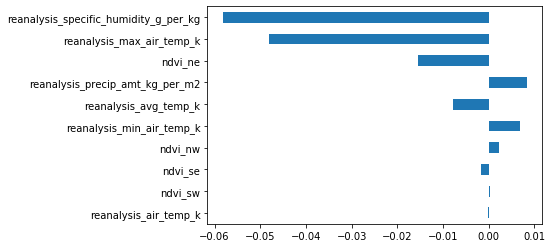

In [36]:
df_perm['imp_mean'].tail(10).plot(kind='barh')

In [37]:
df_perm.sort_values(by='imp_mean', key= abs, ascending=False)

,imp_mean,imp_std
reanalysis_specific_humidity_g_per_kg,-0.058232,0.003548
reanalysis_max_air_temp_k,-0.048064,0.002602
ndvi_ne,-0.015395,0.000982
reanalysis_precip_amt_kg_per_m2,0.008371,0.001577
reanalysis_avg_temp_k,-0.007752,0.000543
reanalysis_min_air_temp_k,0.006902,0.000989
ndvi_nw,0.002177,0.001486
ndvi_se,-0.001791,0.001877
ndvi_sw,0.000300,0.000934
reanalysis_air_temp_k,-0.000276,0.001367


In [38]:
# bring it back to the original scale
np.expm1(df_train_val['total_cases_transformed'])

week_start_date
1990-04-30     4.0
1990-04-30    17.0
1990-04-30    24.0
1990-04-30    17.0
1990-04-30    22.0
              ... 
2010-01-01    30.0
2010-01-01    59.0
2010-01-01    10.0
2010-01-01     9.0
2010-01-01     0.0
Name: total_cases_transformed, Length: 37664, dtype: float64

In [39]:
def check_metrics(model):
  print(model)
  print('Training MAE', mean_absolute_error(np.expm1(y_train),np.expm1(model.predict(X_train))))
  print('Validation MAE', mean_absolute_error(np.expm1(y_val),np.expm1(model.predict(X_val))))
  print('Validation R2', model.score(X_val,y_val))
  #print('Validation R2', model.r2_score(model.predict(X_val),y_val))

model = [model_rf, model_xgb]

for m in model:
  check_metrics(m)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=20,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
         

In [40]:
X_val.columns

Index(['city', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_specific_humidity_g_per_kg'],
      dtype='object')

In [41]:
# features = ['reanalysis_specific_humidity_g_per_kg','reanalysis_max_air_temp_k']
# interact = pdp_interact(model_xgb,
#                         dataset = X_val,
#                         model_features = X_val.columns,
#                         features=features)

# pdp_interact_plot(interact,plot_type='grid',feature_names = features)

In [42]:
#replace nans
X_val[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2','reanalysis_specific_humidity_g_per_kg']] = X_val[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2','reanalysis_specific_humidity_g_per_kg']].fillna(value=X_val[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2','reanalysis_specific_humidity_g_per_kg']].mean())

In [43]:
samp = X_val.tail(1)
samp

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg
week_start_date,,,,,,,,,,,
2010-01-01,iq,0.135085,0.131399,0.189463,0.194687,297.893591,298.428614,302.480399,295.113765,45.502325,16.168596


In [44]:
model_xgb2 = XGBRegressor(random_state=42)
enc=OneHotEncoder()
enc.fit(X_val['city'])
X_val['city'] = enc.transform(X_val['city'])
model_xgb2.fit(X_val,y_val)

[20:08:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [45]:
# explainer = shap.TreeExplainer(model_xgb2)
# shap_values = explainer.shap_values(samp)

# shap.initjs()
# shap.force_plot(base_value=explainer.expected_value,
#                 shap_values = shap_values,
#                 features=samp)


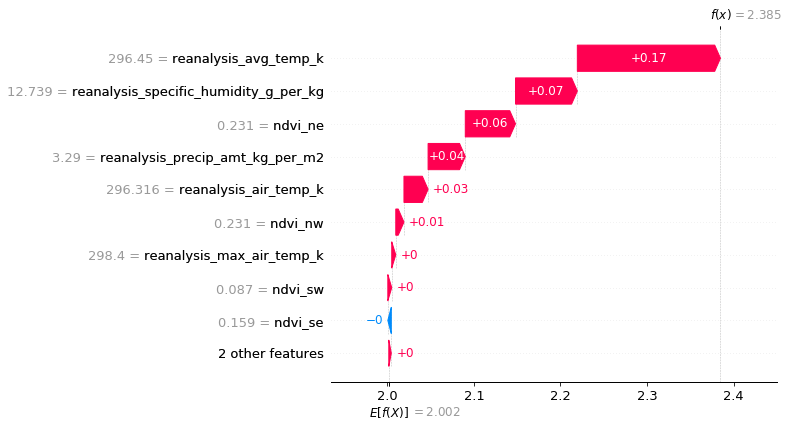

In [46]:
explainer=shap.Explainer(model_xgb2)
shap_values=explainer(X_val)
shap.plots.waterfall(shap_values[0])

In [47]:
X_val['ndvi_ne'].describe()

count    5234.000000
mean        0.135085
std         0.127843
min        -0.406250
25%         0.060200
50%         0.135085
75%         0.220400
max         0.493400
Name: ndvi_ne, dtype: float64

In [48]:
X_val['ndvi_se'].describe()

count    5234.000000
mean        0.189463
std         0.068441
min         0.028343
25%         0.140900
50%         0.187429
75%         0.225971
max         0.383771
Name: ndvi_se, dtype: float64

In [49]:
X_val['ndvi_sw'].describe()

count    5234.000000
mean        0.194687
std         0.072313
min         0.011600
25%         0.137500
50%         0.188229
75%         0.244657
max         0.407486
Name: ndvi_sw, dtype: float64

In [50]:
X_val['ndvi_nw'].describe()

count    5234.000000
mean        0.131399
std         0.115471
min        -0.141200
25%         0.039650
50%         0.131399
75%         0.214843
max         0.424783
Name: ndvi_nw, dtype: float64